# Uncertainty Analysis

---

The uncertainty brought by assmuptions in the calculation procedure is estimated and analyzed in this document.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    
plt.rcParams['figure.dpi'] = 150

# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

In [2]:
# initialize a BWETool object
from emission import BWETool
BWE = BWETool()

## 1 ER-decel curve with different assumptions

Uncertainty from two assumptions is considered:
- **rear/front ratio**: 2/3 of the braking power (and thus emissions) is in front brakes and 1/3 in rear brakes, so the ER of rear brakes is assumed to be 50% of the ER of front brakes.
- **drum/disc ratio**: The PM10 BWP emissions of each rear drum brake are 30% of the emissions of the rear disc brake.

The **rear/front ratio** assumption was derived from a range of 60% to 80% of front brake force proportion. The **drum/disc ratio** assumption was derived from a range of 12.05% to 46.67% of BWP emissions from drum brake to disc brake.

In [18]:
# test grid
f_ratios = np.arange(0.6, 0.81, 0.033)  # front ratio
r_f_ratios = np.round((1 - f_ratios) / f_ratios, 2)  # rear/front ratio
# drum_disc_ratios = np.arange(0.12, 0.49, 0.06)  # drum/disc ratio
drum_disc_ratios = np.linspace(0.1205, 0.4667, 7)  # drum/disc ratio
print(r_f_ratios)
print(drum_disc_ratios)

[0.67 0.58 0.5  0.43 0.37 0.31 0.25]
[0.1205 0.1782 0.2359 0.2936 0.3513 0.409  0.4667]


In [6]:
# ER calculation function
def vehER(
    decel,
    prop_NAO_f = 0.7974,
    prop_LM_f = 0.1775,
    prop_SM_f = 0.0251,
    prop_NAO_r = 0.8186,
    prop_LM_r = 0.1755,
    prop_SM_r = 0.0058,
    prop_drum_f = 0,
    prop_drum_r = 0.2228,
    r_f_ratio = 0.5,  # brake force on front axle vs rear axle
    drum_disc_ratio = 0.3, # ratio of drum emissions to disc emissions 
):
    def pow(x, a, b):
        return a * np.power(x, b)
    
    # mix for disc brake
    ER_f_disc = (pow(decel, *BWE.ER.NAO_POW_PARAM) * prop_NAO_f) \
              + (pow(decel, *BWE.ER.LM_POW_PARAM) * prop_LM_f) \
              + (pow(decel, *BWE.ER.SM_POW_PARAM) * prop_SM_f)
    ER_r_disc = (pow(decel, *BWE.ER.NAO_POW_PARAM) * prop_NAO_r) \
              + (pow(decel, *BWE.ER.LM_POW_PARAM) * prop_LM_r) \
              + (pow(decel, *BWE.ER.SM_POW_PARAM) * prop_SM_r)
    ER_r_disc *= r_f_ratio
    
    # adjust for axles
    ER_f_drum = ER_f_disc * drum_disc_ratio
    ER_r_drum = ER_r_disc * drum_disc_ratio

    # mix for veh
    ER = (1 - prop_drum_f) * ER_f_disc \
        + prop_drum_f * ER_f_drum \
        + (1 - prop_drum_r) * ER_r_disc \
        + prop_drum_r * ER_r_drum
    
    return ER * 2

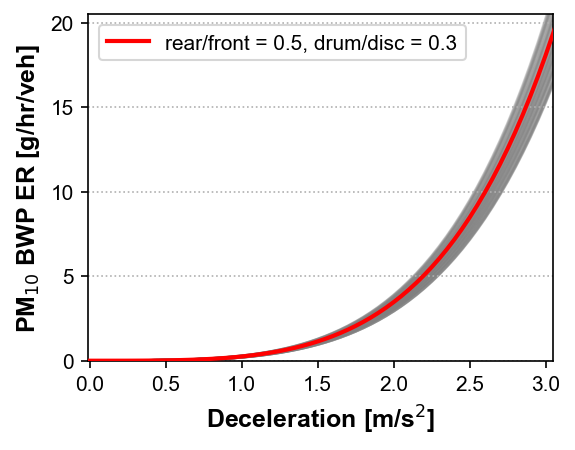

In [11]:
plt.figure(figsize=(4,3))

# plot ER-decel curve under different params
decel = np.arange(0,3.5, 0.05)
for r_f_ratio in r_f_ratios:
    for drum_disc_ratio in drum_disc_ratios:
        ERs = vehER(decel, r_f_ratio=r_f_ratio, drum_disc_ratio=drum_disc_ratio)
        if r_f_ratio == 0.5 and round(drum_disc_ratio, 1) == 0.3:
            plt.plot(decel, ERs, label=f'rear/front = {0.5}, drum/disc = {0.3}', linewidth=2, color='red', zorder=10)
        else:
            plt.plot(decel, ERs, alpha=0.3, color='gray', zorder=1)

# axis and legend
plt.xlim(-0.01, 3.05)
plt.ylim(-0.01, 20.5)
plt.xlabel("Deceleration [m/s$^2$]", fontdict=LABEL_FONT)
plt.ylabel("PM$_{10}$ BWP ER [g/hr/veh]", fontdict=LABEL_FONT)
plt.legend()
plt.grid(axis='y', linestyle=':', zorder=0)
plt.show()

## 2 OpMode ERs with different assumptions

In [12]:
# load OpMode aggregation data
import pickle
with open("./data/agg/agg_OpMode.pkl", 'rb') as f:
    agg_OpMode = pickle.load(f)
agg_OpMode['brakeFrac'] = agg_OpMode['brakeCount'] / agg_OpMode['trajCount']
agg_OpMode['brakeDecelBinFrac'] = agg_OpMode['brakeDecelBinCount'] / agg_OpMode['brakeCount']

In [13]:
# load decel bins
from analysis import Aggregator
agg = Aggregator()
DECEL_BIN = agg.BRAKE_DECEL_BIN

In [14]:
def calOpModeERs(df, r_f_ratio, drum_disc_ratio):
    return df.apply(
        lambda x: sum(vehER(DECEL_BIN[:-1], r_f_ratio=r_f_ratio, drum_disc_ratio=drum_disc_ratio) * x['brakeDecelBinFrac'] * x['brakeFrac']),
        axis=1
    ).to_numpy()

In [15]:
# calculate ER under params
OpModes = [0,1,11,12,13,14,15,16,21,22,23,24,25,27,28,29,30,33,35,37,38,39,40]
OpMode_ERs = {opmode: [] for opmode in OpModes}
for r_f_ratio in r_f_ratios:
    for drum_disc_ratio in drum_disc_ratios:
        er_values = calOpModeERs(agg_OpMode, r_f_ratio, drum_disc_ratio)
        for opmode, er_value in zip(OpModes, er_values):
            OpMode_ERs[opmode].append(er_value)
# calculate ER under assumed params
assumed_ERs = {opmode: [] for opmode in OpModes}
assumed_er_values = calOpModeERs(agg_OpMode, r_f_ratio=0.5, drum_disc_ratio=0.3)
for opmode, er_value in zip(OpModes, assumed_er_values):
        assumed_ERs[opmode].append(er_value)

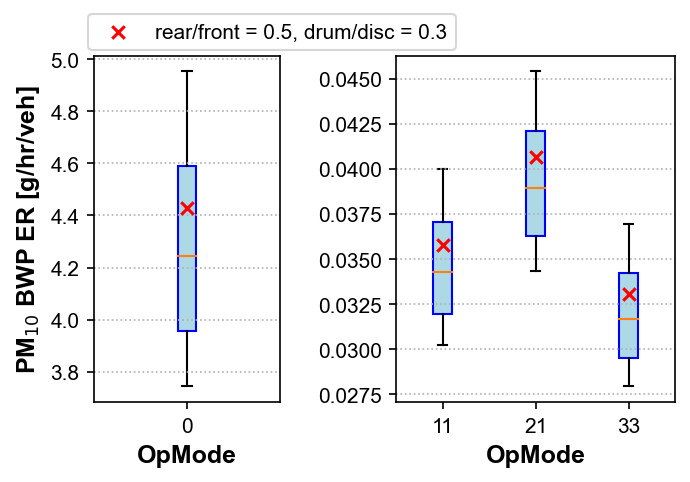

In [16]:
# box plot
fig, ax = plt.subplots(1,2,figsize=(5,3), gridspec_kw={'width_ratios': [1,1.5]})
plt.subplots_adjust(wspace=0.5)

# OpMode0
boxplot_data = [OpMode_ERs[opmode] for opmode in [0]]
ax[0].boxplot(boxplot_data, labels=[0], widths=0.1, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), zorder=1)
ax[0].set_ylabel("PM$_{10}$ BWP ER [g/hr/veh]", fontdict=LABEL_FONT)
ax[0].set_xlabel('OpMode', fontdict=LABEL_FONT)

# OpMode brake
OpModes_brake = [11, 21, 33]
boxplot_data = [OpMode_ERs[opmode] for opmode in OpModes_brake]
ax[1].boxplot(boxplot_data, labels=OpModes_brake, widths=0.2, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), zorder=1)
ax[1].set_xlabel('OpMode', fontdict=LABEL_FONT)

# highlight
ax[0].scatter([1], assumed_ERs[0], color='red', marker='x', label=f'rear/front={0.5}, drum/disc={0.3}', zorder=10)
ax[1].scatter(range(1,4), [assumed_ERs[i] for i in OpModes_brake], color='red', marker='x', label=f'rear/front = {0.5}, drum/disc = {0.3}', zorder=10)

# axis and legend
ax[1].legend(bbox_to_anchor=(0.25, 1.15), bbox_transform=ax[1].transAxes)
ax[0].grid(axis='y', linestyle=':', zorder=0)
ax[1].grid(axis='y', linestyle=':', zorder=0)
plt.show()

In [17]:
for i in [0,11,21,33]:
    ERs = OpMode_ERs[i]
    print('OpMode %d | max: %.3f | min: %.3f | assumed: %.3f' % (i, max(ERs), min(ERs), assumed_ERs[i][0]))

OpMode 0 | max: 4.954 | min: 3.744 | assumed: 4.431
OpMode 11 | max: 0.040 | min: 0.030 | assumed: 0.036
OpMode 21 | max: 0.045 | min: 0.034 | assumed: 0.041
OpMode 33 | max: 0.037 | min: 0.028 | assumed: 0.033


## 3 Overall average EF with different assumptions

In [19]:
import pickle
with open("./data/agg/agg_link.pkl", 'rb') as f:
    agg_link = pickle.load(f)

# parameter calculation
def calEF(aggFile, r_f_ratio, drum_disc_ratio):
    OpModeERs = np.nan_to_num(calOpModeERs(agg_OpMode, r_f_ratio, drum_disc_ratio))
    aggFile.dropna(inplace=True)
    aggFile['OpModeFrac'] = aggFile['OpModeCount'] / aggFile['trajCount']
    aggFile['PM10 ER Avg'] = aggFile['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
    aggFile['Daily BWE'] = aggFile['PM10 ER Avg'] * aggFile['trajCount'] / 3600 / 30
    aggFile['PM10 EF Avg'] = aggFile['Daily BWE'] * 30 / aggFile['mileage'] * 1000  # mg/km/veh
    aggFile.replace(np.inf, 0, inplace=True)
    weight = 'trajCount'
    aggFile.fillna(0, inplace=True)
    weighted_ave_EF = sum(aggFile['PM10 EF Avg'] * aggFile[weight]) / aggFile[weight].sum()
    return weighted_ave_EF

In [20]:
EFs = {'rear/front':[], 'drum/disc':[], 'EF':[]}
for r_f_ratio in r_f_ratios:
    for drum_disc_ratio in drum_disc_ratios:
        ef = calEF(agg_link, r_f_ratio, drum_disc_ratio)
        EFs['rear/front'].append(r_f_ratio)
        EFs['drum/disc'].append(drum_disc_ratio)
        EFs['EF'].append(ef)
EFs = pd.DataFrame(EFs)

In [28]:
calEF(agg_link, r_f_ratio=0.5, drum_disc_ratio=0.3)

26.848007965344415

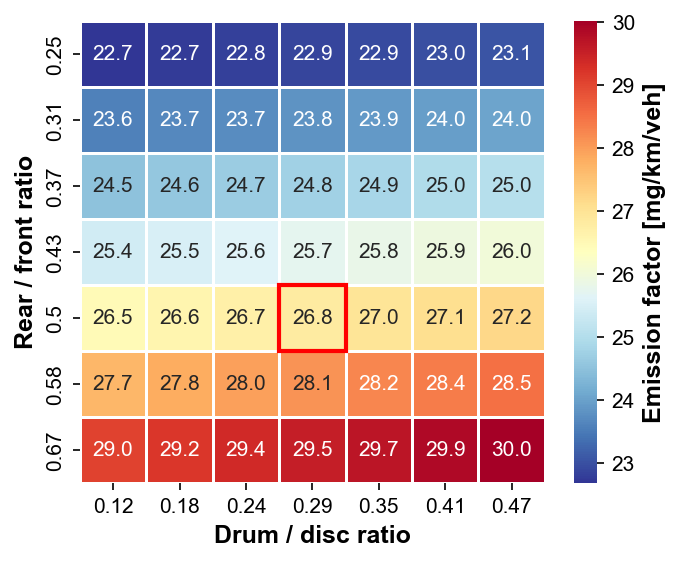

In [29]:
import seaborn as sns
from matplotlib.patches import Rectangle
# heat map
plt.figure(figsize=(5,4))
pivot_table = EFs.pivot(index='rear/front', columns='drum/disc', values='EF')
pivot_table.columns = np.round(pivot_table.columns, decimals=2)
ax = sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlBu_r', linecolor='white', linewidths=0.5)

# colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('Emission factor [mg/km/veh]', fontdict=LABEL_FONT)

# highlight
row = 0.5
col = 0.29
row_index = pivot_table.index.tolist().index(row)
col_index = pivot_table.columns.tolist().index(col)
ax.add_patch(Rectangle((col_index, row_index), 1, 1, fill=False, edgecolor='red', lw=2))

# axis and label
plt.xlabel('Drum / disc ratio', fontdict=LABEL_FONT)
plt.ylabel('Rear / front ratio', fontdict=LABEL_FONT)
plt.show()